#Introduction


**Fashion MNIST** is a dataset of Zalando's article images instead of hand-written digits like the old MNIST. This dataset contains **70.000** images: it consists of a training set of **60.0000** images and a test set of **10.000** images. Each image is a 28x28 grayscale associated with a label from 10 different labels.

# Imports

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.utils import to_categorical
from matplotlib.pyplot import figure, show
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')
import matplotlib.style as style
from sklearn.model_selection import train_test_split
from keras.layers import Input, Concatenate,concatenate, Dense, Embedding, Dropout, Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, History
from keras.layers import Dropout, Flatten, GlobalAveragePooling2D, Activation
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.applications.resnet50 import ResNet50
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint
from keras.applications.vgg16 import VGG16
from keras.utils import to_categorical
from sklearn.utils import class_weight
from keras.layers.normalization import BatchNormalization
from matplotlib import pyplot as plt
from keras import backend as K
from keras.optimizers import SGD
from keras.models import Model
import seaborn as sns
import numpy as np
import argparse
import time
import glob
import cv2
import numpy
import os
import glob
import sys
import os
import json
import pprint
import warnings
warnings.filterwarnings('ignore')

# Load data

In [2]:
!curl -L -O https://www.dropbox.com/s/heyqll2my8uw0tq/fashionmnist.zip
!unzip  fashionmnist.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  1034    0  1034    0     0    815      0 --:--:--  0:00:01 --:--:--   815
100 68.7M  100 68.7M    0     0  23.2M      0  0:00:02  0:00:02 --:--:-- 57.9M
Archive:  fashionmnist.zip
  inflating: fashion-mnist_test.csv  
  inflating: fashion-mnist_train.csv  
  inflating: t10k-images-idx3-ubyte  
  inflating: t10k-labels-idx1-ubyte  
  inflating: train-images-idx3-ubyte  
  inflating: train-labels-idx1-ubyte  


In [4]:
#Load training and test data using dataframes from Pandas.
train = pd.read_csv("fashion-mnist_train.csv") 
test = pd.read_csv("fashion-mnist_test.csv")
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,0,0,105,92,101,107,100,132,0,0,2,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,150,...,211,220,214,74,0,255,222,128,0,0,0,0,0,0,0,0,0,44,12,0,0,40,134,162,191,214,163,146,165,79,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,0,114,183,112,55,23,72,102,165,160,28,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,24,188,163,93,...,171,249,207,197,202,45,0,3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,22,21,25,69,52,45,74,39,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,0,0,0,46,0,21,68,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,187,189,...,230,237,229,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,68,116,112,136,147,144,121,102,63,0,0,0,0,0,0,0,0,0,0


In [0]:
img_rows, img_cols = 28, 28
input_shape = (img_rows, img_cols, 1)

X = train.iloc[:,1:]
Y = train.iloc[:,:1]
X_test = test.iloc[:,1:]
Y_test = test.iloc[:,:1]

#Normalization
X = np.asarray(X).reshape(X.shape[0],img_rows,img_cols,1)
X_test = np.asarray(X_test).reshape(X_test.shape[0],img_rows,img_cols,1)
X = (255. - X) / 255.
X_test = (255. - X_test) / 255.

#Number of classes
classes = len(Y['label'].value_counts())



In [6]:
print("Number of features: ", X.shape[1])
print("Number of train samples: ", X.shape[0])
print("Number of test samples: ", X_test.shape[0])

Number of features:  28
Number of train samples:  60000
Number of test samples:  10000


We can plot the different classes and in the following figures we can see that our dataset is balanced.

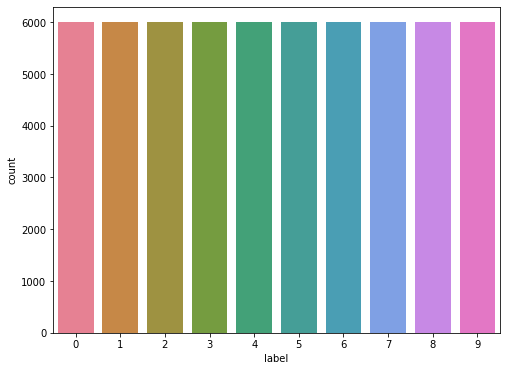

In [7]:
figure(figsize=(8,6))
ax = sns.countplot(x=Y['label'], data=Y, palette="husl")


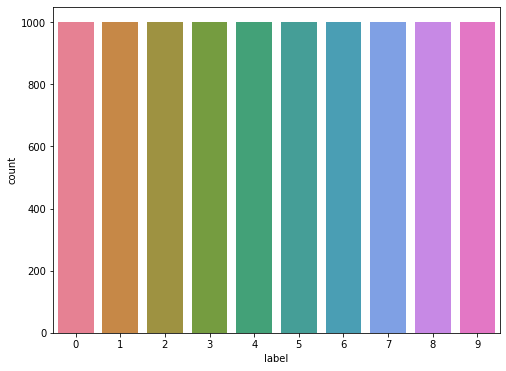

In [8]:
figure(figsize=(8,6))
ax = sns.countplot(x=Y_test['label'], data=Y_test,palette="husl")

Let's visualize a sample.

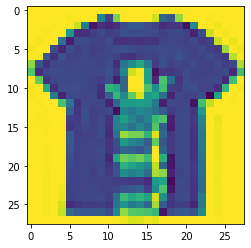

In [9]:
sample = X[13,:].reshape(28,28)
plt.imshow(sample)
plt.show()

#Training

Separate into train / test / validation sets.

In [0]:
Y_test = to_categorical(Y_test)
Y = to_categorical(Y)
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, stratify=Y, test_size=0.2,  random_state=66)

## Parameters

In [0]:
lrr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, epsilon=1e-3, mode='min')
early_stopping = EarlyStopping(monitor='val_loss',patience=5,verbose=0, mode='auto')
checkpoint = ModelCheckpoint("checkpoint.hdf5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')
batch_size = 64
epochs = 10

In [0]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
# define the grid search parameters
batch_size = [16, 32, 64, 80]
epochs = [10, 25, 50]
param_grid = dict(batch_size=batch_size, epochs=epochs)
model = KerasClassifier(build_fn=model_basic, verbose=0)
grid = GridSearchCV(estimator=model, param_grid=param_grid,n_jobs=1, cv=3)
grid_result = grid.fit(X_train, Y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

## Model definition

This model is a simple CNN classifier with only 1 convolution layer, max-pooling layer and finally, a dense layer. Moreover, a dropout of 25% is added.

In [0]:
def model_basic(classes=classes,optimizer='adam'):
  kernel_size = (3,3)
  dropout = 0.25
  pool_size = (2,2)
  inputs = Input(shape=(img_rows, img_cols, 1))
  y = Conv2D(filters=32, kernel_size=kernel_size,activation='relu',padding='same')(inputs)
  y = MaxPooling2D(pool_size=pool_size,strides=(2,2))(y)
  y = Dropout(dropout)(y) 
  
  y = Flatten()(y)

  y = Dense(256,activation='relu')(y)
  y = BatchNormalization()(y)
  y = Dropout(dropout)(y)
  outputs = Dense(classes, activation='softmax')(y)

  model = Model(inputs=inputs, outputs=outputs)
  model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [15]:
basic_model = model_basic()
basic_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               1605888   
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024

In [18]:
import warnings
warnings.filterwarnings('ignore')
history = basic_model.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_val, Y_val))

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 82s 2ms/step - loss: 0.4390 - acc: 0.8470 - val_loss: 0.4019 - val_acc: 0.8618
Epoch 2/10
48000/48000 [==============================] - 82s 2ms/step - loss: 0.3458 - acc: 0.8776 - val_loss: 0.3046 - val_acc: 0.8932
Epoch 3/10
48000/48000 [==============================] - 82s 2ms/step - loss: 0.3110 - acc: 0.8883 - val_loss: 0.2947 - val_acc: 0.8953
Epoch 4/10
48000/48000 [==============================] - 81s 2ms/step - loss: 0.2935 - acc: 0.8937 - val_loss: 0.2772 - val_acc: 0.9024
Epoch 5/10
48000/48000 [==============================] - 85s 2ms/step - loss: 0.2710 - acc: 0.9030 - val_loss: 0.2855 - val_acc: 0.8952
Epoch 6/10
48000/48000 [==============================] - 84s 2ms/step - loss: 0.2592 - acc: 0.9067 - val_loss: 0.2574 - val_acc: 0.9063
Epoch 7/10
48000/48000 [==============================] - 85s 2ms/step - loss: 0.2450 - acc: 0.9107 - val_loss: 0.2773 - val_acc

In [19]:
score = basic_model.evaluate(X_test,Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.2463475521683693
Test accuracy: 0.9137


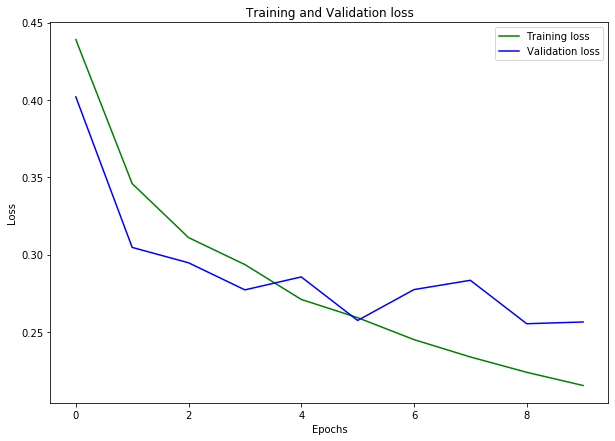

In [20]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(len(loss_train))
plt.figure(figsize=(10,7))
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()
plt.show()

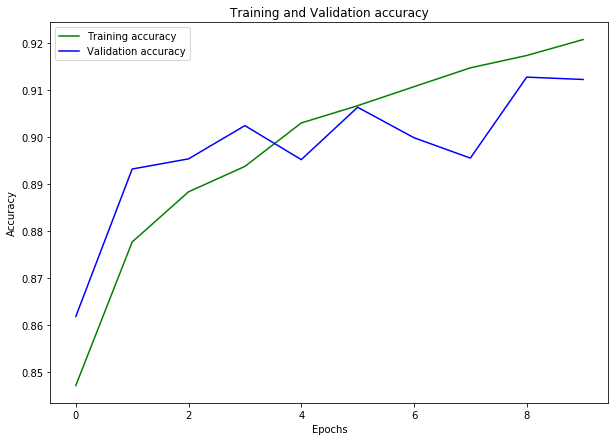

In [21]:
acc_train = history.history['acc']
acc_val = history.history['val_acc']
plt.figure(figsize=(10,7))
plt.plot(epochs, acc_train, 'g', label='Training accuracy')
plt.plot(epochs, acc_val, 'b', label='Validation accuracy')

plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [22]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
y_pred = basic_model.predict(X_test)
Y_pred_classes = np.argmax(y_pred,axis = 1) 
Y_true = np.argmax(Y_test,axis = 1) 
acc = accuracy_score(Y_true,Y_pred_classes)
class_report = classification_report(Y_true,Y_pred_classes)
#confusion_matrix = confusion_matrix(Y_true,Y_pred_classes)


print('The accuracy: {}'.format(acc))
print('The Classification Report:\n {}'.format(class_report))


The accuracy: 0.9137
The Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.81      0.85      1000
           1       0.99      0.99      0.99      1000
           2       0.93      0.80      0.86      1000
           3       0.90      0.94      0.92      1000
           4       0.85      0.91      0.88      1000
           5       0.98      0.98      0.98      1000
           6       0.71      0.81      0.76      1000
           7       0.95      0.97      0.96      1000
           8       0.99      0.97      0.98      1000
           9       0.97      0.96      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.92      0.91      0.91     10000
weighted avg       0.92      0.91      0.91     10000



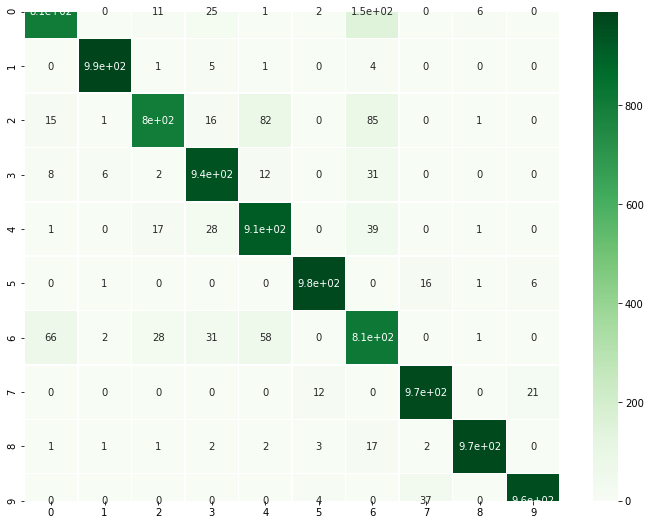

In [23]:
import seaborn as sns
cm = confusion_matrix(Y_true, Y_pred_classes)
plt.figure(figsize = (12,9))
sns.heatmap(cm, annot=True,cmap="Greens",linewidths=.5)